In [2]:

import yaml
import os
import pandas as pd
from numpy import *
import luxeics
import h5py

from scipy.interpolate import interp2d,RectBivariateSpline

import matplotlib.pyplot as plt

import luxeics


def Photon_density(xoffset,yoffset,X1,X2,baseline,spotsize,sigmaT,W,path,K0):
    
    
    Area=pi*spotsize**2

    
    selector= sqrt((xoffset+X1)**2+(yoffset+X2)**2) < spotsize


#     print ( f'IP-laser spot size: {spotsize:.2f} micron')
#     print ( f'baseline          : {baseline/1e6:.2f} metres')
#     print ('-'*42)

#     print (f'photons in spot')
#     print (f'macrophoton weight               : {amax(W):.4g}')
    
#     print ( 'macrophotons, finite source size :',sum( selector) )
    
#     print ( 'photon weight, finite source size:',sum(W[selector ] ) )
    
    
    P=sum(W[selector ] )/Area
    
#     print ( f'Photon density, finite source size:',P)
    
#     print (' ######################################### '  )
#     print ('                           '  )
#     plt.figure(figsize=(14,6))

    

#     ax1=plt.subplot(122,aspect=1)

#     # plot(X1+xoffset, X2+yoffset, color='m', marker=',',lw=0);





#     plt.scatter(X1+xoffset, X2+yoffset, color='m', marker='.',lw=0,s=W);

#     plt.xlim(-2*spotsize,2*spotsize)
#     plt.ylim(-2*spotsize,2*spotsize)
    
#     plt.xlabel(r'$x$ (micron)')
#     plt.ylabel(r'$y$ (micron)');
#     plt.title(f'Finite source size, Photon density:{round(P,2)} micron^(-2)')

    
#     ax1.add_patch(plt.Circle((0,0),spotsize,color='C0',fill=False))


#     plt.suptitle(f' sigmaT :{sigmaT} micron ; spotsize:{spotsize} micron')
#     plt.savefig(f'{path}\photon_spectrum_at_focus_{sigmaT}_{spotsize}.png',dpi=200)
    K_inside_Spot=K0[selector]
    W_inside_Spot=W[selector]
#     df = pd.DataFrame(K0[selector])
#     df.to_csv(f'{path}\Energy_Photons_Spotsize{spotsize}_sigmaT_{sigmaT}.txt',header=None , index=None, sep="\t", mode='w')
    plt.figure(figsize=(10,6))

    plt.subplot(111)
    plt.hist(K0[selector]/1e9,bins=linspace(6,9,50),weights=W[selector],alpha=1  ,fc='C0',label=f'SigmaT_{sigmaT}_Spotsize_{spotsize}');
     
    plt.xlim(6,9)
    plt.legend()
    plt.xlabel('ICS photon energy (GeV)')
    plt.ylabel('photon spectrum at IP')
    
    plt.savefig(f'{path}\photon_spectrum_at_focus_SigmaT_{sigmaT}_Spotsize_{spotsize}.png',dpi=200)
    return(P,K_inside_Spot+1j*sigmaT,W_inside_Spot)
                                      
    
                                   
def run(spotsize,input_filename,path):
    

    
    
    with h5py.File(input_filename + '.h5' ,'r') as ff:
    #     omega      = ff['final-state/spectrum/omega'][:]/1e9
    #     theta      = ff['final-state/spectrum/theta'][:]*1e6
    #     spectrum   = ff['final-state/spectrum/spectrum'][:]

        K0,K1,K2,K3  = ff['final-state/photon/momentum'][:].T
        X0,X1,X2,X3  = ff['final-state/photon/position'][:].T
        W            = ff['final-state/photon/weight'  ][:]

        P0,P1,P2,P3  = ff['final-state/electron/momentum'][:].T
    #     X0,X1,X2,X3  = ff['final-state/photon/position'][:].T
    #     We            = ff['final-state/photon/weight'  ][:]
    with open( input_filename + '.yml', 'r' ) as stream:
        input_dict = yaml.load(stream, Loader=yaml.SafeLoader)

        mode             = input_dict['control']['mode']


        beam_charge      = float( input_dict['beam']['beam_charge'])
        number_electrons = int( beam_charge / 1.60217653e-19)

    #     sampling         = input_dict['control']['sampling']
        sampling = mode

        w0               = float(input_dict['laser']['w0'])
        omega0           = float(input_dict['laser']['omega0'])
        gamma            = float(input_dict['beam']['gamma'])
        Xr               = 4*gamma*omega0/511*10**(-3)
        energyspread     = float(input_dict['beam']['energyspread'])
        sigmaT   = float(input_dict['beam']['sigmaT'])
#     print (f'beam charge                              : {beam_charge*1e12:.24} pC')
#     print (f'number of beam electrons                 : {number_electrons:.3e}')
#     print ('-'*42)
#     print (f'{sampling} sampling:')
#     print (f'max  single photon weight                : {amax(W):.4g}')
#     print (f'mean single photon weight                : {mean(W):.4g}')
#     print (f'total photon weight                      : {sum(W):.4g}')
#     print (f'total photon weight per incident electron: {sum(W)/number_electrons:.4g}')
#     print (f'total macro photon number                : {len(W)}')
#     print ('-'*42)
#     print(f' Frequency (Laser) :  {omega0}'  )
#     print(f'Recoil Factor:{Xr}')
#     print (' ######################################### '  )
#     print ('                           '  )
    baseline = 7.5e6

    thetax=K1/K3
    thetay=K2/K3

     

    xoffset = thetax * baseline
    yoffset = thetay * baseline
    
    Pd,K_inside_Spot,W_inside_Spot=Photon_density(xoffset,yoffset,X1,X2,baseline,spotsize,sigmaT,W,path,K0)
    
    
    
    
    return(Pd,K_inside_Spot,W_inside_Spot)

In [3]:


input_filename = "New"
n=10
sigma=zeros(n)
r=1 #Number of runs
Pd = ones((n,2,r))
spotsize1=3
spotsize2=10
directory = "Sigma_T_PARARUN_Histogram_1_2_0"
parent_dir = f"{os. getcwd()}\Photon_Density"
path = os.path.join(parent_dir, directory)
os.mkdir(path)

K1=[]# for spotsize 1
K2=[]# for spotsize 2
W1=[]# for spotsize 1
W2=[]# for spotsize 2
'''

Energy= I0 * pi* (w0 **2)* T_fwhm
I0= (omega*m*a0)**2/(8*pi*alpha)

a0*w0= constant

'''
Energy = zeros((n,r))

            
            
                    
for j in range(r):
    for i in range(n):
        with open( input_filename+'.yml', 'r' ) as stream:
            input_dict = yaml.load(stream, Loader=yaml.SafeLoader)
            sigma1= 5+i*5

            input_dict['beam']['sigmaT']=sigma1
            input_dict['control']['name']=f'{path}\SigmaT{sigma1}'
            
            
            ###Comment the previous line to just to do a parameter run in sigmaT
            input_filename1 = f'SigmaT{sigma1}'


        with open(      f'{path}\SigmaT{sigma1}'+'.yml', 'w') as file:
            documents = yaml.dump(input_dict, file)

        # import matplotlib.pyplot as plt

        sigma[i]=sigma1


        with open( f'{path}\SigmaT{sigma1}'+'.yml', 'r' ) as stream:
            input_dict = yaml.load(stream, Loader=yaml.SafeLoader)

        #print (input_dict)



        luxeics.main_program( f'{path}\SigmaT{sigma1}'+'.yml' )

        Pd[i,0,j],K_temp,W_temp=run(spotsize1,f'{path}\SigmaT{sigma1}',path)
        Pd[i,1,j],K_temp1,W_temp1=run(spotsize2,f'{path}\SigmaT{sigma1}',path)
        K1.append(K_temp)
        K2.append(K_temp1)
        W1.append(W_temp)
        W2.append(W_temp1)


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\Dupish\\Documents\\GitHub\\luxeics\\Photon_Density\\Sigma_T_PARARUN_Histogram_1_2_0'

In [35]:
print(sigma)
print(Energy*10**(-9))

[ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50.]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [ ]:
# plt.plot(sigma,Pd[:,0],label=f'{spotsize1} microns')
# plt.plot(sigma,Pd[:,1],label=f'{spotsize2} microns')
# plt.xlabel('SigmaT [microns]')
# plt.ylabel(r'Photon Density [microns^(-2)]')
# plt.legend()
# plt.title('Zero Source Size')
# plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Zero.png',dpi=200)

In [ ]:
# plt.plot(sigma,Pd[:,0],label=f'{spotsize1} microns')
# plt.plot(sigma,Pd[:,1],label=f'{spotsize2} microns')
# plt.xlabel('SigmaT [microns]')
# plt.ylabel('Photon Density [microns^(-2)]')
# plt.title('Finite Source Size')
# plt.legend()
# plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Finite.png',dpi=200)

In [74]:
import numpy as np
Pd_Mean=np.ones((n,2))

Pd_STD=np.ones((n,2))
for i in range(n):

    Pd_Mean[i,0]=np.mean(Pd[i,0,:])
    Pd_STD[i,0]=np.std(Pd[i,0,:])
    Pd_Mean[i,1]=np.mean(Pd[i,1,:])
    Pd_STD[i,1]=np.std(Pd[i,1,:])

In [75]:
print(np.shape(Pd))

(10, 2, 1)


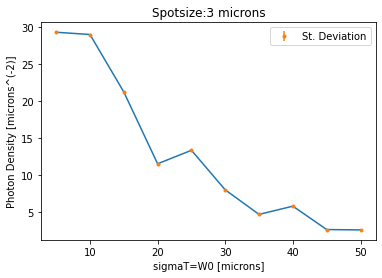

In [76]:
plt.plot(sigma,Pd_Mean[:,0])
plt.errorbar(sigma,Pd_Mean[:,0],Pd_STD[:,0], linestyle='None', marker='.',label='St. Deviation')
plt.xlabel('sigmaT=W0 [microns]')
plt.ylabel('Photon Density [microns^(-2)]')
plt.title(f'Spotsize:{spotsize1} microns')
plt.legend()
plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Spotsize{spotsize1}_Finite.png',dpi=200)

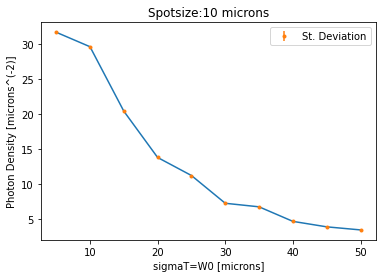

In [77]:
plt.plot(sigma,Pd_Mean[:,1])
plt.errorbar(sigma,Pd_Mean[:,1],Pd_STD[:,1], linestyle='None', marker='.',label='St. Deviation')
plt.xlabel('sigmaT=W0 [microns]')
plt.ylabel('Photon Density [microns^(-2)]')
plt.title(f'Spotsize:{spotsize2} microns')
plt.legend()
plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Spotsize{spotsize2}_Finite.png',dpi=200)

In [ ]:
# import pandas as pd
# import numpy as np
# import os
# Data=np.zeros((n,3))
# Data[:,0]=sigma
# Data[:,1]=Pd[:,0]
# Data[:,2]=Pd[:,1]
# df=pd.DataFrame(Data)

# List=["Sigma","3 microns              ","10 microns"]
# df.to_csv(f'{path}\Photon_Density.txt',header=List , index=None, sep="\t", mode='w')



# print(df)

In [78]:
'''
Saving the Data
'''


import pandas as pd
import numpy as np
import os
Data=np.zeros((n,r+1))
Data[:,0]=sigma
Data[:,1:r+1]=Pd[:,0,0:r]
df=pd.DataFrame(Data)

List=["SigmaT","Photon Density "]
df.to_csv(f'{path}\Photon_Density_Spotsize{spotsize1}.txt',header=List , index=None, sep="\t", mode='w')



print(df)

      0          1
0   5.0  29.300151
1  10.0  28.993810
2  15.0  21.223361
3  20.0  11.511541
4  25.0  13.338213
5  30.0   7.983457
6  35.0   4.667111
7  40.0   5.780440
8  45.0   2.617738
9  50.0   2.569242


In [81]:

DatatempK1=list(chain.from_iterable(K1))
DatatempK2=list(chain.from_iterable(K2))

DatatempW1=list(chain.from_iterable(W1))
DatatempW2=list(chain.from_iterable(W2))

Data1=np.zeros((len(DatatempK1),2),complex)

Data1[:,0]=DatatempK1
Data1[:,1]=DatatempW1

Data2=np.zeros((len(DatatempK2),2),complex)


Data2[:,0]=DatatempK2

Data2[:,1]=DatatempW2



df1=pd.DataFrame(Data1)
df2=pd.DataFrame(Data2)



List1=["Energy(eV)+1j*SigmaT (microns) ","Weights"]
df1.to_csv(f'{path}\Photon_Energy_Spotsize{spotsize1}.txt',header=List1 , index=None, sep="\t", mode='w')
df2.to_csv(f'{path}\Photon_Energy_Spotsize{spotsize2}.txt',header=List1 , index=None, sep="\t", mode='w')


In [82]:

Data=np.zeros((n,r+1))
Data[:,0]=sigma
Data[:,1:r+1]=Pd[:,1,0:r]
df=pd.DataFrame(Data)

List=["SigmaT","Photon Density "]
df.to_csv(f'{path}\Photon_Density_Spotsize{spotsize2}.txt',header=List , index=None, sep="\t", mode='w')



print(df)

      0          1
0   5.0  31.715941
1  10.0  29.646670
2  15.0  20.437957
3  20.0  13.815541
4  25.0  11.237293
5  30.0   7.269911
6  35.0   6.761906
7  40.0   4.682415
8  45.0   3.900969
9  50.0   3.461692


In [83]:
'''
Reading the text files
The final array p does not contain the Header files

'''
print(pd.read_csv(f'{path}\Photon_Density_Spotsize{spotsize2}.txt',header=None , sep="\t"))

r=pd.read_csv(f'{path}\Photon_Density_Spotsize{spotsize2}.txt',header=0 , sep="\t")
p=pd.DataFrame.to_numpy(r)


         0                   1
0   SigmaT     Photon Density 
1      5.0  31.715941013287274
2     10.0  29.646669865623156
3     15.0  20.437956702126378
4     20.0  13.815540904309177
5     25.0  11.237293386490975
6     30.0    7.26991080460711
7     35.0   6.761906374479018
8     40.0   4.682415013806798
9     45.0  3.9009691761142054
10    50.0   3.461692309110242



Histograms

[]


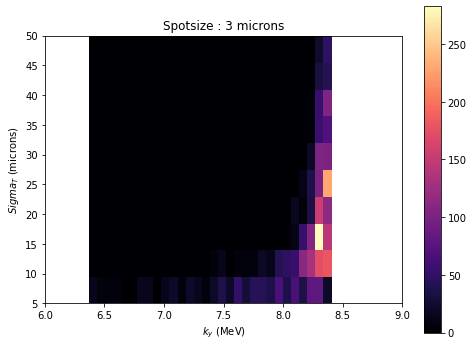

In [86]:
from itertools import chain
plt.figure(figsize=(8,6))
import h5py
import yaml
from scipy.interpolate import interp2d,RectBivariateSpline
import numpy as np
plt.subplot(111,aspect=0.05)

temp= list(chain.from_iterable(K1))
# 
plt.hist2d(np.real(temp)/1e9,np.imag(temp),bins=(30,10),weights=DatatempW1,rasterized=True,cmap=plt.cm.magma);
plt.colorbar()
plt.xlim(6,9)

plt.ylabel(r'$Sigma_T$ (microns)')
plt.xlabel(r'$k_y$ (MeV)')

plt.title('Spotsize : 3 microns')

plt.savefig(f'Photon_Density_Histogram_{spotsize1}_microns_Sigma_ParameterRun_w0_Constant.pdf')


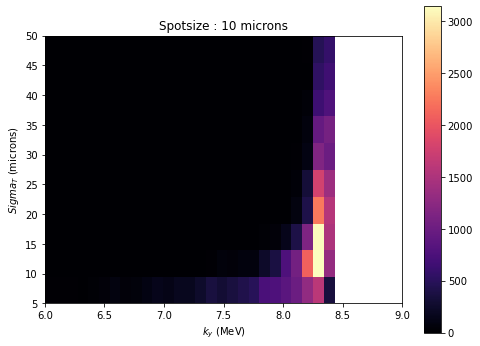

In [87]:
from itertools import chain
plt.figure(figsize=(8,6))
import h5py
import yaml
from scipy.interpolate import interp2d,RectBivariateSpline
import numpy as np
plt.subplot(111,aspect=0.05)

temp=flatten_list = list(chain.from_iterable(K2))
# 
plt.hist2d(np.real(temp)/1e9,np.imag(temp),bins=(30,10),weights=DatatempW2, rasterized=True,cmap=plt.cm.magma);
plt.colorbar()
plt.xlim(6,9)

plt.ylabel(r'$Sigma_T$ (microns)')
plt.xlabel(r'$k_y$ (MeV)')
plt.title('Spotsize : 10 microns')
plt.savefig(f'Photon_Density_Histogram_{spotsize2}_microns_Sigma_ParameterRun_w0_Constant.pdf')


In [89]:
!python --version

Python 3.8.8


In [91]:
!matplotlib --version

Traceback (most recent call last):
  File "C:\Users\Dupish\anaconda3\Scripts\matplotlib-script.py", line 10, in <module>
    sys.exit(plotting._matplotlib())
AttributeError: module 'pandas.plotting' has no attribute '_matplotlib'


In [95]:
plt?

In [96]:
os.sep

'\\'